In [2]:
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import parser
from pyspark.sql.functions import unix_timestamp, date_format, col, when
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

StatementMeta(, , , Waiting, )

In [2]:
from azureml.opendatasets import NycTlcYellow

end_date = parser.parse('2018-06-06')
start_date = parser.parse('2018-05-01')
nyc_tlc = NycTlcYellow(start_date=start_date, end_date=end_date)
filtered_df = nyc_tlc.to_spark_dataframe()

StatementMeta(jbjsynspark, 0, 2, Finished, Available)

In [3]:
# To make development easier, faster, and less expensive, downsample for now
sampled_taxi_df = filtered_df.sample(True, 0.001, seed=1234)

StatementMeta(jbjsynspark, 0, 3, Finished, Available)

In [4]:
#sampled_taxi_df.show(5)
display(sampled_taxi_df)

StatementMeta(jbjsynspark, 0, 4, Finished, Available)

SynapseWidget(Synapse.DataFrame, 92e2dc11-75f6-449c-9cf6-7b80f6e41cb3)

In [5]:
sampled_taxi_df.createOrReplaceTempView("nytaxi")

StatementMeta(jbjsynspark, 0, 5, Finished, Available)

In [6]:
taxi_df = sampled_taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'rateCodeId', 'passengerCount'\
                                , 'tripDistance', 'tpepPickupDateTime', 'tpepDropoffDateTime'\
                                , date_format('tpepPickupDateTime', 'hh').alias('pickupHour')\
                                , date_format('tpepPickupDateTime', 'EEEE').alias('weekdayString')\
                                , (unix_timestamp(col('tpepDropoffDateTime')) - unix_timestamp(col('tpepPickupDateTime'))).alias('tripTimeSecs')\
                                , (when(col('tipAmount') > 0, 1).otherwise(0)).alias('tipped')
                                )\
                        .filter((sampled_taxi_df.passengerCount > 0) & (sampled_taxi_df.passengerCount < 8)\
                                & (sampled_taxi_df.tipAmount >= 0) & (sampled_taxi_df.tipAmount <= 25)\
                                & (sampled_taxi_df.fareAmount >= 1) & (sampled_taxi_df.fareAmount <= 250)\
                                & (sampled_taxi_df.tipAmount < sampled_taxi_df.fareAmount)\
                                & (sampled_taxi_df.tripDistance > 0) & (sampled_taxi_df.tripDistance <= 100)\
                                & (sampled_taxi_df.rateCodeId <= 5)
                                & (sampled_taxi_df.paymentType.isin({"1", "2"}))
                                )

StatementMeta(jbjsynspark, 0, 6, Finished, Available)

In [7]:
taxi_featurised_df = taxi_df.select('totalAmount', 'fareAmount', 'tipAmount', 'paymentType', 'passengerCount'\
                                                , 'tripDistance', 'weekdayString', 'pickupHour','tripTimeSecs','tipped'\
                                                , when((taxi_df.pickupHour <= 6) | (taxi_df.pickupHour >= 20),"Night")\
                                                .when((taxi_df.pickupHour >= 7) & (taxi_df.pickupHour <= 10), "AMRush")\
                                                .when((taxi_df.pickupHour >= 11) & (taxi_df.pickupHour <= 15), "Afternoon")\
                                                .when((taxi_df.pickupHour >= 16) & (taxi_df.pickupHour <= 19), "PMRush")\
                                                .otherwise(0).alias('trafficTimeBins')
                                              )\
                                       .filter((taxi_df.tripTimeSecs >= 30) & (taxi_df.tripTimeSecs <= 7200))

StatementMeta(jbjsynspark, 0, 7, Finished, Available)

In [8]:
# Because the sample uses an algorithm that works only with numeric features, convert them so they can be consumed
sI1 = StringIndexer(inputCol="trafficTimeBins", outputCol="trafficTimeBinsIndex")
en1 = OneHotEncoder(dropLast=False, inputCol="trafficTimeBinsIndex", outputCol="trafficTimeBinsVec")
sI2 = StringIndexer(inputCol="weekdayString", outputCol="weekdayIndex")
en2 = OneHotEncoder(dropLast=False, inputCol="weekdayIndex", outputCol="weekdayVec")

# Create a new DataFrame that has had the encodings applied
encoded_final_df = Pipeline(stages=[sI1, en1, sI2, en2]).fit(taxi_featurised_df).transform(taxi_featurised_df)

StatementMeta(jbjsynspark, 0, 8, Finished, Available)

In [9]:
# Decide on the split between training and testing data from the DataFrame
trainingFraction = 0.7
testingFraction = (1-trainingFraction)
seed = 1234

# Split the DataFrame into test and training DataFrames
train_data_df, test_data_df = encoded_final_df.randomSplit([trainingFraction, testingFraction], seed=seed)

StatementMeta(jbjsynspark, 0, 9, Finished, Available)

In [10]:
## Create a new logistic regression object for the model
logReg = LogisticRegression(maxIter=10, regParam=0.3, labelCol = 'tipped')

## The formula for the model
classFormula = RFormula(formula="tipped ~ pickupHour + weekdayVec + passengerCount + tripTimeSecs + tripDistance + fareAmount + paymentType+ trafficTimeBinsVec")

## Undertake training and create a logistic regression model
lrModel = Pipeline(stages=[classFormula, logReg]).fit(train_data_df)

## Saving the model is optional, but it's another form of inter-session cache
datestamp = datetime.now().strftime('%m-%d-%Y-%s')
fileName = "lrModel_" + datestamp
logRegDirfilename = fileName
lrModel.save(logRegDirfilename)

## Predict tip 1/0 (yes/no) on the test dataset; evaluation using area under ROC
predictions = lrModel.transform(test_data_df)
predictionAndLabels = predictions.select("label","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

StatementMeta(jbjsynspark, 0, 10, Finished, Available)

Area under ROC = 0.9790013999066729

StatementMeta(jbjsynspark, 0, 11, Finished, Available)

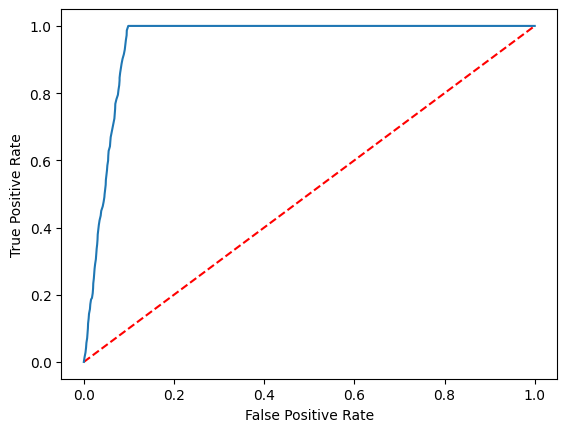

In [11]:
## Plot the ROC curve; no need for pandas, because this uses the modelSummary object
modelSummary = lrModel.stages[-1].summary

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(modelSummary.roc.select('FPR').collect(),
         modelSummary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()